# FIT5149 S1 2020 Assessment 1: Bushfire Analysis using Meteorological Data

Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used:
- library(ggplot2)
- library(psych)
- library(lattice)
- library(dummies)
- library(olsrr)
- require(leaps)
- library(caret)
- library(e1071)
- library(randomForest)

## Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Comparison](#sec_4)
* [Variable Identification and Explanation](#sec_5)
* [Conclusion](#sec_6)
* [References](#sec_7)

## 1. Introduction <a class="anchor" id="sec_1"></a>

In this task, we are interested in exploring machine learning approaches to predict the burned area of bushfires by using meteorological data that are known to influence the wild fires.<br> The dataset that we are going to use here were originally collected from the northeast region of Portugal between January 2000 and December 2003. It contains geographical information, fire weather indices, and the corresponding weather conditions. <br> 
The aim is to build statistical models that can predict the burned area of the bushfires. <br><br> Specifically, the problem we are going to solve is: <br>
Can we <br>
• accurately predict the burned area of a bushfire given the collected data? <br>
• well explain your prediction and the associated findings? For example,
identify the key factors are strongly associated with the response variable,
i.e., the burned area.

#### DATASET 
The dataset contains 517 fire instances, each of which have 13 columns: <br> The first 12 columns corresponding to the attributes (e.g., spatial coordinates, month, day, four fire indices, and other meteorological data) and the last column containing the burned area, i.e., the variable that we will predict.

In [1]:
# reading the .csv data
bush_data = read.csv('forestfires.csv')

In [2]:
#dimension
dim(bush_data)
#feature names
names(bush_data)
# peek at top 5 rows in data
head(bush_data)

[1] 517  13

[1] "X"     "Y"     "month" "day"   "FFMC"  "DMC"   "DC"    "ISI"   "temp" 
[10] "RH"    "wind"  "rain"  "area"

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


Dataset has 13 features and a total of 517 observations. <br>

#### Feature Information <br>
   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
      (this output variable is very skewed towards 0.0, thus it may make
     sense to model with the logarithm transform).



## 2. Data Exploration<a class="anchor" id="sec_2"></a>

We will first check data type. 

In [3]:
str(bush_data)

'data.frame':	517 obs. of  13 variables:
 $ X    : int  7 7 7 8 8 8 8 8 8 7 ...
 $ Y    : int  5 4 4 6 6 6 6 6 6 5 ...
 $ month: Factor w/ 12 levels "apr","aug","dec",..: 8 11 11 8 8 2 2 2 12 12 ...
 $ day  : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC  : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC   : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI  : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH   : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area : num  0 0 0 0 0 0 0 0 0 0 ...


Features "month" and "day" are categorical while others are numeric

In [4]:
# different levels of categorical data
levels(bush_data$month)
levels(bush_data$day)

[1] "apr" "aug" "dec" "feb" "jan" "jul" "jun" "mar" "may" "nov" "oct" "sep"

[1] "fri" "mon" "sat" "sun" "thu" "tue" "wed"

### Working on AREA variable
### Now let us have a look at the distribution of our target variable "Area"

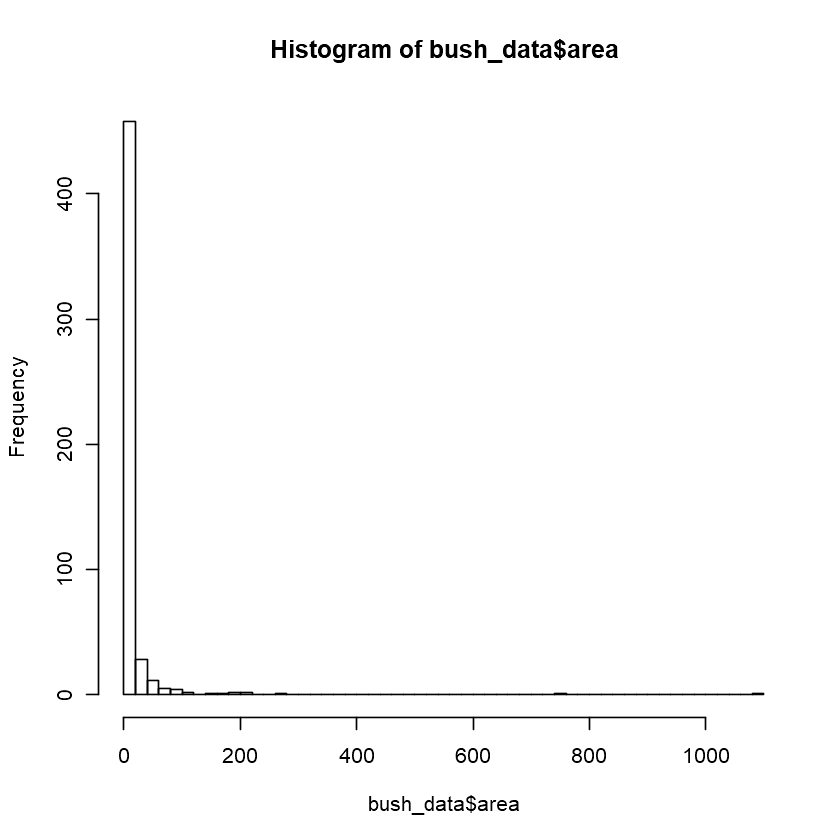

In [5]:
hist(bush_data$area, 40)

#### In order to engineer the area variable we will consider the values that are non zero. The same obserations will be later used to for outliers checks
We can conclude from the above plot that the target variale is highly skewed.Most of the burned area is under 50 hectares.In order to make its distributin normal we will take ***logarithmic values*** for all values where each value is greater than zero(0)

In [6]:
bush_data$logarea <- ifelse(bush_data$area > 0, log(bush_data$area), NA)
head(bush_data)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logarea
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0,NA
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,NA
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,NA
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0,NA
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,NA
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0,NA


Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"Use of `bush_data$logarea` is discouraged. Use `logarea` instead."Warning message:
"Use of `bush_data$logarea` is discouraged. Use `logarea` instead."`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 247 rows containing non-finite values (stat_bin)."

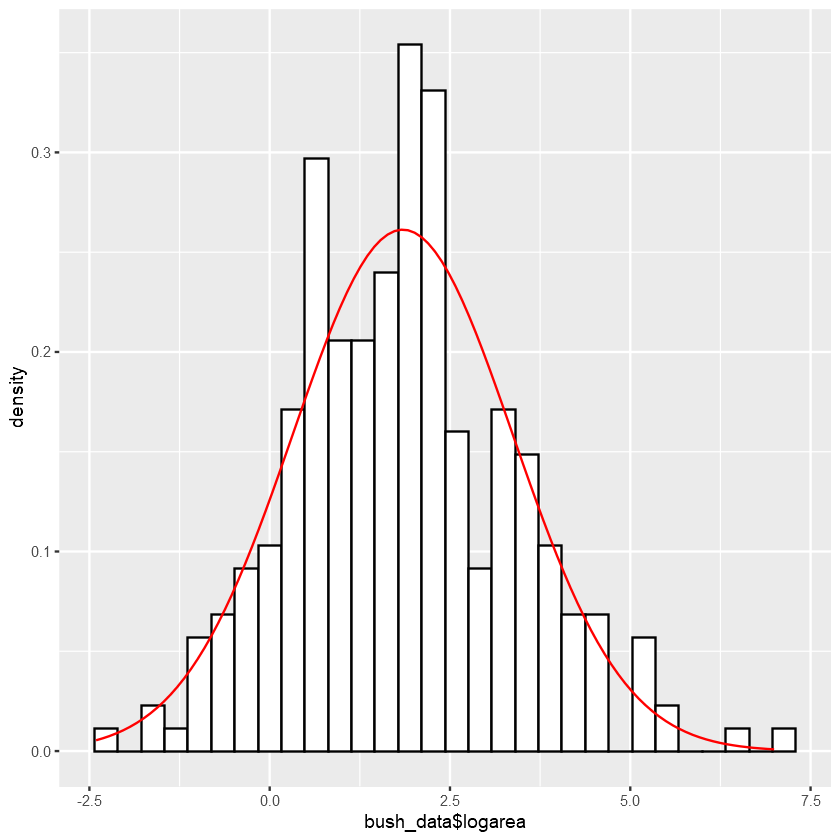

In [7]:
library(ggplot2)
# plotting the target variable 
ggplot(bush_data, aes(x = bush_data$logarea)) + 
  geom_histogram(aes(y = ..density..), colour = "black", fill = "White") +
  stat_function(fun = dnorm, args = list(mean = mean(bush_data$logarea,na.rm=TRUE), sd = sd(bush_data$logarea,na.rm=TRUE)),col = 'red')

#### Now we will do the outlier check for our target variable <br>
We will use Cook’s Distance to detect the abnormal patterns. <br>
In order to detect the outliers or influential points we require only the observations were "area">0, as area is highly skewed with multiple observations having area=0

In [8]:
positive_area_data = bush_data[which(bush_data$area > 0),]

In [9]:
head(positive_area_data)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logarea
139,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0,0.36,-1.0216512
140,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0,0.43,-0.8439701
141,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0,0.47,-0.7550226
142,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0,0.55,-0.5978370
143,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0,0.61,-0.4942963
144,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0,0.71,-0.3424903


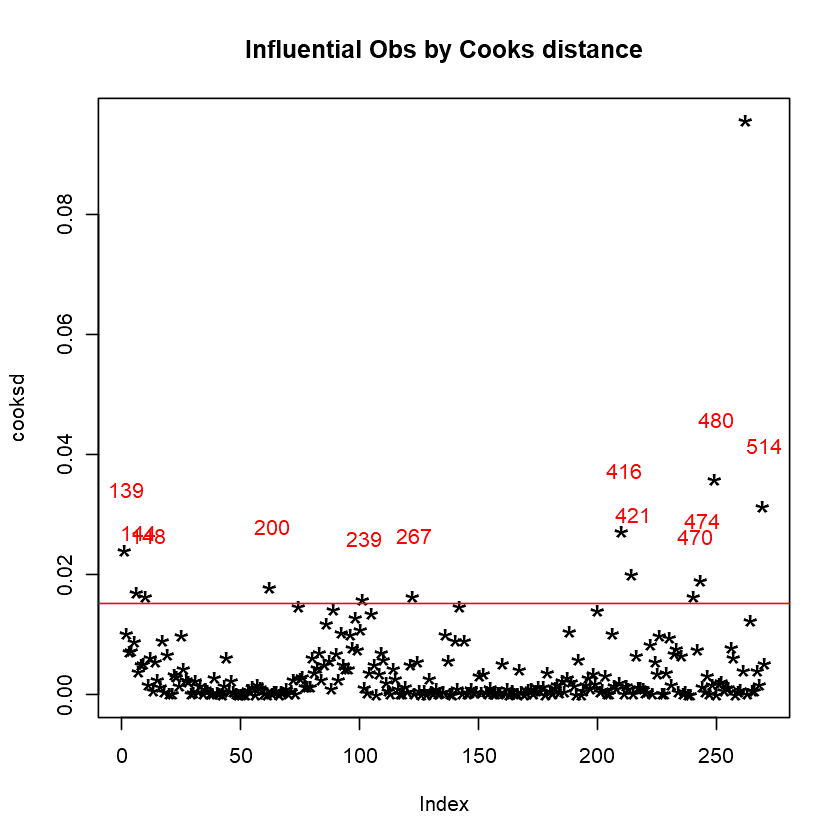

In [10]:
mod <- lm(logarea ~ ., data=positive_area_data[c(seq(1,12),14)])
cooksd <- cooks.distance(mod)
plot(cooksd, pch="*", cex=2, main="Influential Obs by Cooks distance")  # plot cook's distance
abline(h = 4*mean(cooksd, na.rm=T), col="red")  # add cutoff line
text(x=1:length(cooksd)+1, y=cooksd+0.01, labels=ifelse(cooksd>4*mean(cooksd, na.rm=T),names(cooksd),""), col="red")  # add labels

In [11]:
# Influential points
influential = which(cooksd>4*mean(cooksd, na.rm=T))
positive_area_data[influential, ]
dim(positive_area_data)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logarea
139,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36,-1.02165125
144,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0.0,0.71,-0.34249031
148,8,3,sep,tue,84.4,73.4,671.9,3.2,24.2,28,3.6,0.0,0.96,-0.04082199
200,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0.0,11.32,2.42657107
239,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84,6.99470332
267,6,5,aug,tue,94.3,131.7,607.1,22.7,19.4,55,4.0,0.0,0.17,-1.77195684
416,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28,6.61510086
421,8,8,aug,wed,91.7,191.4,635.9,7.8,26.2,36,4.5,0.0,185.76,5.22445552
470,6,3,apr,sun,91.0,14.6,25.6,12.3,13.7,33,9.4,0.0,61.13,4.11300274
474,9,4,jun,sat,90.5,61.1,252.6,9.4,24.5,50,3.1,0.0,70.32,4.25305625


[1] 270  14

##### Range values for numerical features <br>
* FFMC - 18.7 to 96.20
* DMC -1.1 to 291.3 
* DC -7.9 to 860.6 
* ISI -0.0 to 56.10
* temp -2.2 to 33.30
* RH -15.0 to 100
* wind -0.40 to 9.40 
* rain -0.0 to 6.4 
* area -0.00 to 1090.84 

#### Some high value observations <br>
* No.139,200,239,500,514 have very high DC
* No.239,416 have very high Area value.

##### For now, let's remove outliers.

In [12]:
positive_area_data <- subset(positive_area_data, select = -c(logarea))
bush_data <- subset(bush_data, select = -c(logarea))

In [13]:
# removing influential points
new_positive_area_data = positive_area_data[-influential, ]

In [14]:
head(new_positive_area_data)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
140,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0,0.43
141,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0,0.47
142,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0,0.55
143,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0,0.61
145,2,5,aug,wed,95.5,99.9,513.3,13.2,23.8,32,5.4,0,0.77
146,6,5,aug,thu,95.2,131.7,578.8,10.4,27.4,22,4.0,0,0.90


***Now we will combine the new_positive_area_data (outliers removed data) with the data where area for observations =0*** 

In [15]:
new_bush_data <- rbind(bush_data[which(bush_data$area == 0),],new_positive_area_data)
head(new_bush_data)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


In [16]:
dim(new_bush_data)

[1] 504  13

In [17]:
str(new_bush_data)

'data.frame':	504 obs. of  13 variables:
 $ X    : int  7 7 7 8 8 8 8 8 8 7 ...
 $ Y    : int  5 4 4 6 6 6 6 6 6 5 ...
 $ month: Factor w/ 12 levels "apr","aug","dec",..: 8 11 11 8 8 2 2 2 12 12 ...
 $ day  : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC  : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC   : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI  : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH   : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area : num  0 0 0 0 0 0 0 0 0 0 ...


### Analysis of the categorical columns

Now we will analyse categorical features. <br>
We wil be checking which months or days counted for most fires. For this we will be using positive_bush_data wherein area>0

##### MONTH

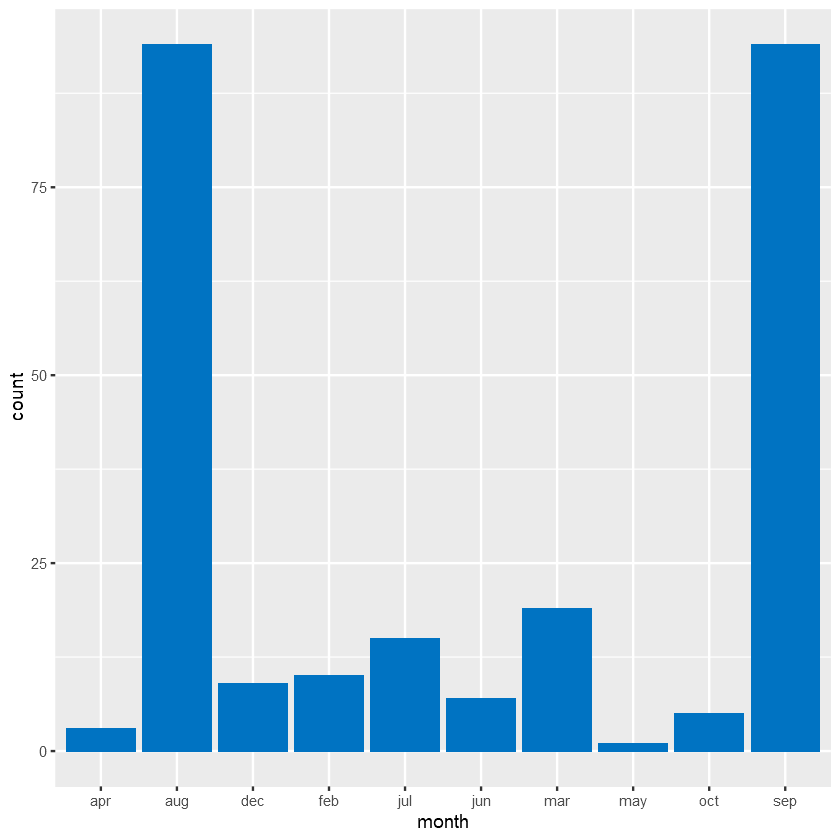

In [18]:
library(ggplot2)
ggplot(new_positive_area_data,aes(month))+geom_bar(fill = "#0073C2FF")

* Maximum of the fires have taken place during months August and september 
* Months with minimum fire occurences are April and May

##### DAYS

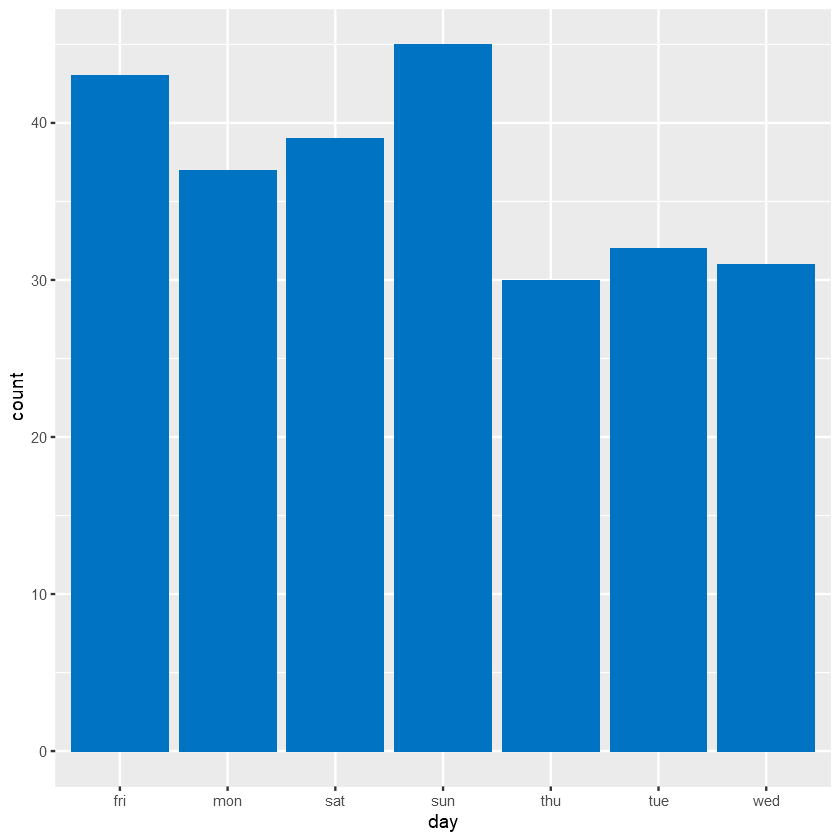

In [19]:
ggplot(new_positive_area_data,aes(day))+geom_bar(fill = "#0073C2FF")

* We can conclude from the above plot that fires instances are somewhat evenly distributed across all days, with maximum on Sunday and minimum on Thursday

### additional statistics of features

In [20]:
library(psych)
round(describe(new_bush_data), 3)

Warning message:
"package 'psych' was built under R version 3.6.3"
Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha



,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X,1,504,4.633,2.294,4.00,4.631,2.965,1.0,9.00,8.00,0.049,-1.168,0.102
Y,2,504,4.288,1.206,4.00,4.304,1.483,2.0,9.00,7.00,0.319,1.200,0.054
month*,3,504,6.790,4.377,7.00,6.757,7.413,1.0,12.00,11.00,0.071,-1.725,0.195
day*,4,504,3.720,1.929,4.00,3.651,2.965,1.0,7.00,6.00,0.166,-1.105,0.086
FFMC,5,504,90.710,5.419,91.60,91.491,1.927,18.7,96.20,77.50,-6.864,72.408,0.241
DMC,6,504,111.098,64.104,108.30,106.723,50.557,1.1,291.30,290.20,0.542,0.200,2.855
DC,7,504,548.959,248.864,664.20,580.043,118.905,7.9,860.60,852.70,-1.100,-0.259,11.085
ISI,8,504,9.028,4.523,8.40,8.735,3.113,0.0,56.10,56.10,2.611,22.345,0.201
temp,9,504,18.802,5.818,19.20,18.993,5.337,2.2,33.30,31.10,-0.313,0.115,0.259
RH,10,504,44.280,16.373,41.50,42.676,14.085,15.0,100.00,85.00,0.867,0.426,0.729


Some observations from the Summary:

* We have max observations for the months aug and sep
* Feature "area" has a high range from 0 to 1090.84

#### Hist Distribution and box plots for all numeric features

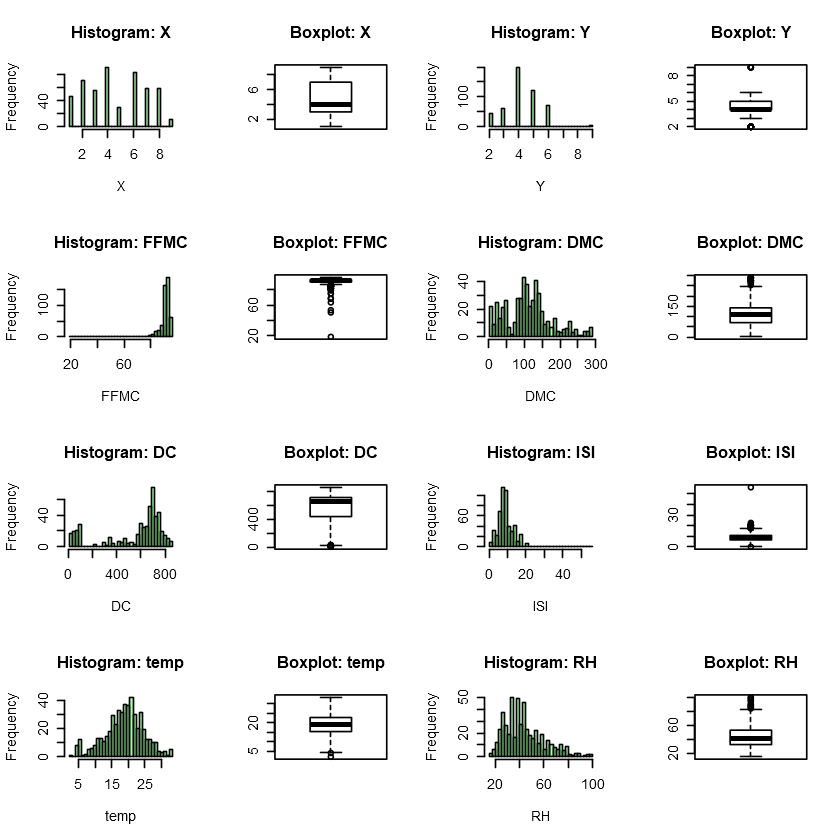

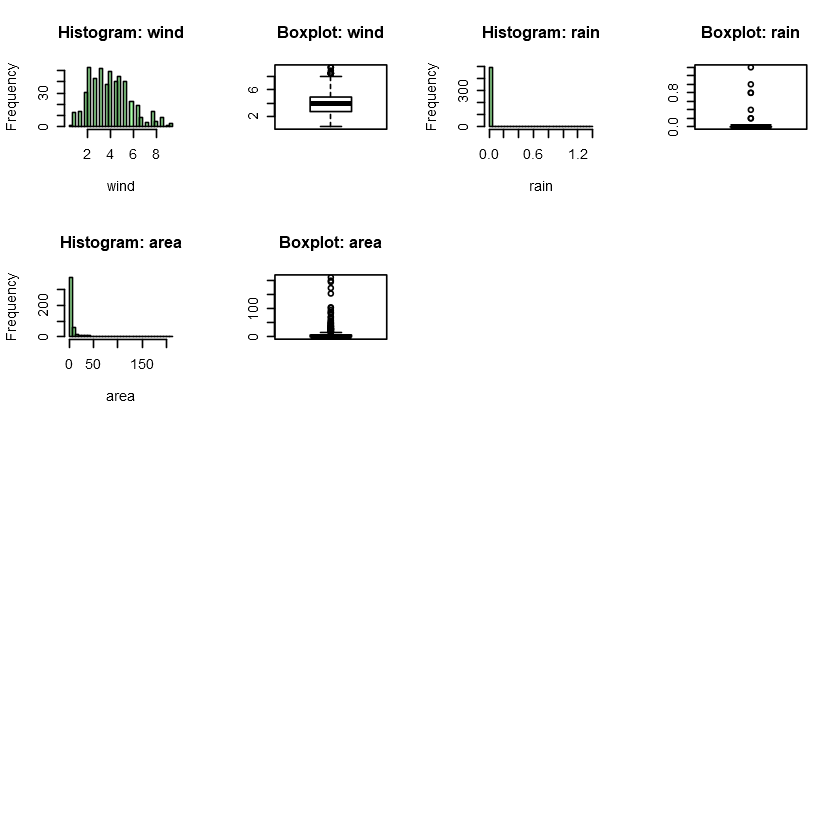

In [21]:
# Define a two-row by two-column plotting area.
par(mfrow = c(4, 4))

# Plot a histogram and box plot for each of the numeric predictors,
factor = sapply(new_bush_data,is.factor)
for (x in colnames(new_bush_data)) {
    if (factor[x] == FALSE){
        min_d <- min(new_bush_data[ , x])
        max_d <- max(new_bush_data[ , x])
        b <- seq(min_d, max_d, length.out = 35)
        hist(new_bush_data[ , x], col = rgb(0, 1, 0, 0.35), breaks = b,
             main = paste("Histogram: ", x, sep = ""), xlab = x)
        boxplot(new_bush_data[ , x], main = paste("Boxplot: ", x, sep = ""))}
}

Findings from distribution plots: <br>
* **FFMC** is left skewed with skewness = -6.537
* **ISI** shows slight right skewness = 2.522
* **rain** and **area** show maximum right skewness, values 19.702 and 12.772 respectively

#### Feature Correlation

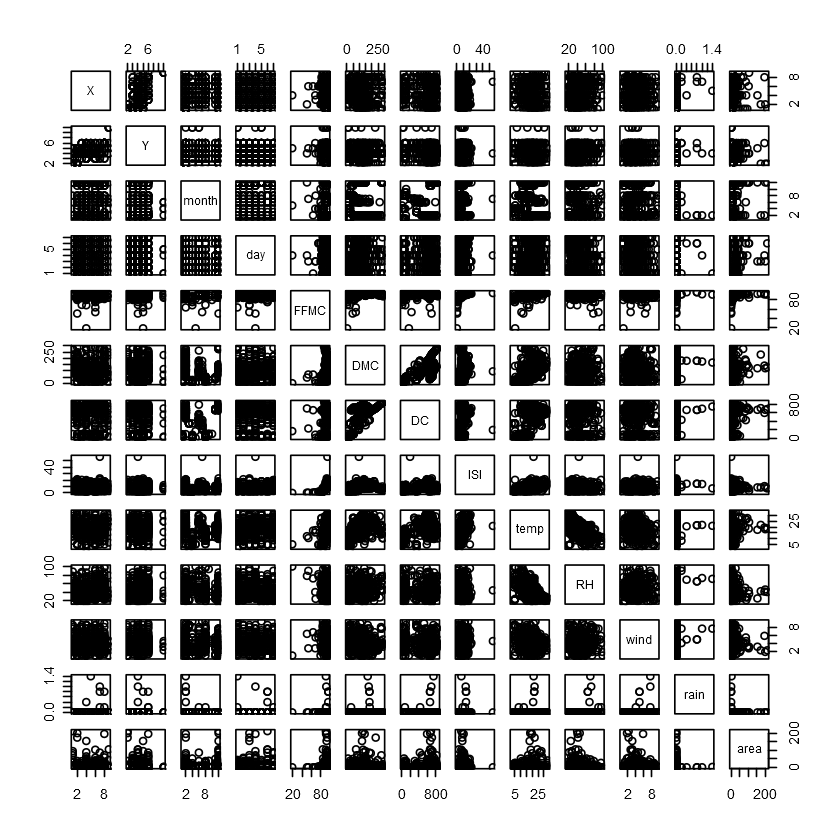

In [22]:
# scatter plots for all features vs all features
pairs(new_bush_data)

Some interesting relationships: <br>
 * DMC and DC show positive correlation
 * X and Y show a positive correlation
 * RH and temp show a negative correlation


#### Correlation matrix for all numeric features

In [23]:
# names in order to exclude categorical features
names = names(new_bush_data) %in% c('month','day')
cor(new_bush_data[!names])

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000000,0.537779420,-0.03654498,-0.057520119,-0.08428593,-0.001657554,-0.06983774,0.09642733,0.02122606,0.07718071,-0.01776863
Y,0.537779420,1.000000000,-0.05420732,-0.007789737,-0.11108913,-0.026543535,-0.03903907,0.07073876,-0.01001214,0.03194400,-0.04683598
FFMC,-0.036544984,-0.054207325,1.00000000,0.381307502,0.34694348,0.523590307,0.45402031,-0.31438379,-0.03228663,0.04911858,0.04454649
DMC,-0.057520119,-0.007789737,0.38130750,1.000000000,0.68263210,0.301165366,0.46925102,0.07818773,-0.10191489,0.09280720,0.07654039
DC,-0.084285930,-0.111089127,0.34694348,0.682632100,1.00000000,0.237489818,0.49732078,-0.03939224,-0.19767186,0.04805269,0.07139269
ISI,-0.001657554,-0.026543535,0.52359031,0.301165366,0.23748982,1.000000000,0.40848125,-0.13859827,0.10487384,0.06228027,-0.01539200
temp,-0.069837737,-0.039039070,0.45402031,0.469251018,0.49732078,0.408481254,1.00000000,-0.53679816,-0.23027343,0.02988337,0.04489494
RH,0.096427331,0.070738763,-0.31438379,0.078187730,-0.03939224,-0.138598274,-0.53679816,1.00000000,0.06991922,0.16664459,-0.06253788
wind,0.021226057,-0.010012143,-0.03228663,-0.101914891,-0.19767186,0.104873842,-0.23027343,0.06991922,1.00000000,0.13177423,-0.02605011
rain,0.077180708,0.031943998,0.04911858,0.092807195,0.04805269,0.062280271,0.02988337,0.16664459,0.13177423,1.00000000,-0.03308293


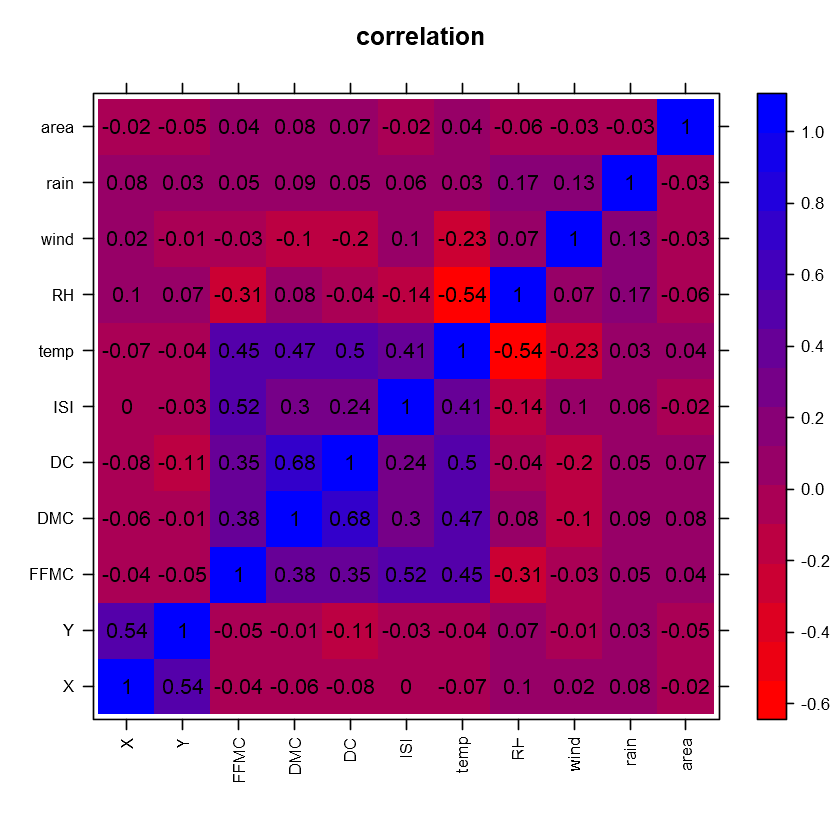

In [24]:
library(lattice)
#Define you own panel
myPanel <- function(x, y, z, ...) {
    panel.levelplot(x,y,z,...)
    panel.text(x, y, round(z, 2))
}
#Define the color scheme
cols = colorRampPalette(c("red","blue"))
#Plot the correlation matrix.
levelplot(cor(new_bush_data[!names]), col.regions = cols(100), main = "correlation", xlab = NULL, ylab = NULL, 
          scales = list(x = list(rot = 90)), panel = myPanel)

**Summary of strong correlations found between features**
* DMC and DC show positive correlation of 0.68
* X and Y show a positive correlation of 0.54
* ISI and FFMC show a positive correlation of 0.53
* RH and temp show a negative correlation of -0.53

## 3. Model Development<a class="anchor" id="sec_3"></a>

Development till now: <br>
* Untill now we have visualised the correlated features
* We have removed few outliers from our data

In [25]:
#original data with outliers
head(bush_data)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


In [26]:
# new data after outlier removal
head(new_bush_data)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


#### Now we will apply a basic linear model on both original and new dataset to see if outlier removal was any good

In [27]:
fit1 <- lm(area ~ ., data=bush_data)
summary(fit1)


Call:
lm(formula = area ~ ., data = bush_data)

Residuals:
    Min      1Q  Median      3Q     Max 
 -55.32  -17.84   -6.82    4.99 1039.28 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -15.16402   76.56086  -0.198   0.8431  
X             2.25583    1.49786   1.506   0.1327  
Y            -0.14765    2.81881  -0.052   0.9582  
monthaug     46.88205   38.08792   1.231   0.2190  
monthdec     47.37821   36.94830   1.282   0.2004  
monthfeb      5.58985   25.94816   0.215   0.8295  
monthjan     14.76909   56.40617   0.262   0.7936  
monthjul     28.87889   33.05232   0.874   0.3827  
monthjun      6.71548   30.33765   0.221   0.8249  
monthmar     -4.22256   23.41447  -0.180   0.8570  
monthmay     12.79646   50.91572   0.251   0.8017  
monthnov     -4.41010   68.37767  -0.064   0.9486  
monthoct     68.97536   45.42009   1.519   0.1295  
monthsep     73.73192   42.67672   1.728   0.0847 .
daymon        5.96928   10.48154   0.570   0.5693  
daysat     

In [28]:
fit1_no_outlier <- lm(area ~ ., data=new_bush_data)
summary(fit1_no_outlier)


Call:
lm(formula = area ~ ., data = new_bush_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.876  -9.510  -4.416   1.039 188.869 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 17.09944   28.84695   0.593 0.553620    
X            0.57521    0.54922   1.047 0.295487    
Y           -1.40169    1.04456  -1.342 0.180269    
monthaug    33.28241   14.19949   2.344 0.019493 *  
monthdec    29.80992   13.66696   2.181 0.029660 *  
monthfeb     4.28119    9.68358   0.442 0.658612    
monthjan     4.28310   20.57191   0.208 0.835161    
monthjul    23.00788   12.52557   1.837 0.066852 .  
monthjun    11.85962   11.41268   1.039 0.299257    
monthmar     1.31069    8.87693   0.148 0.882680    
monthmay    20.91351   18.51176   1.130 0.259154    
monthnov    -9.56954   24.76088  -0.386 0.699315    
monthoct    43.25728   16.79797   2.575 0.010320 *  
monthsep    46.99919   15.89553   2.957 0.003263 ** 
daymon       0.23379    3.80408   0.061 0.95

On comparing the two models we can conclude that 'fit1_no_outlier' is better because: <br>
* Reduced residual standard error
* Improved Adjusted R-squared value <br>

For our future model developments we will be using the **new_bush_data** dataset which has no outliers

In [29]:
head(new_bush_data)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


#### DUMMY ENCODING

***As we saw earlier that our dataset has two categorical columns month and day. It would be a good option to use dummy encoding to encode our categorical columns into binary.***

In [30]:
# install.packages("dummies")
library(dummies)
new_bush_data.encoded <- dummy.data.frame(new_bush_data, names = c("month","day") , sep = ".")
head(new_bush_data.encoded)

dummies-1.5.6 provided by Decision Patterns

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"

X,Y,month.apr,month.aug,month.dec,month.feb,month.jan,month.jul,month.jun,month.mar,...,day.wed,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,0,0,0,0,0,0,0,1,...,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,0,0,0,0,0,0,0,0,...,0,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,0,0,0,0,0,0,0,0,...,0,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,0,0,0,0,0,0,0,1,...,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,0,0,0,0,0,0,0,1,...,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,0,1,0,0,0,0,0,0,...,0,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


#### Now let us check feature correlations after DUMMY ENCODING and OUTLIER removal

In [31]:
cor(new_bush_data.encoded)

,X,Y,month.apr,month.aug,month.dec,month.feb,month.jan,month.jul,month.jun,month.mar,...,day.wed,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000000,0.537779420,0.061903137,-0.063853315,-0.004552850,0.045863463,-0.044974163,0.058164233,0.117887574,0.01349594,...,0.012571591,-0.036544984,-0.0575201195,-0.084285930,-0.0016575537,-0.06983774,0.096427331,0.021226057,0.077180708,-0.01776863
Y,0.537779420,1.000000000,0.009204466,-0.025807770,0.079736080,0.018951803,0.011124710,0.054159014,0.088284318,0.05572868,...,0.036255802,-0.054207325,-0.0077897367,-0.111089127,-0.0265435355,-0.03903907,0.070738763,-0.010012143,0.031943998,-0.04683598
month.apr,0.061903137,0.009204466,1.000000000,-0.094251656,-0.017124694,-0.025816447,-0.008016177,-0.031380246,-0.022996102,-0.04399413,...,0.008214440,-0.130722939,-0.1884420174,-0.254153667,-0.1269250838,-0.15216637,0.033738640,0.005276057,-0.012894909,-0.03192345
month.aug,-0.063853315,-0.025807770,-0.094251656,1.000000000,-0.100069906,-0.150861059,-0.046843353,-0.183373692,-0.134380086,-0.25708424,...,0.069964813,0.225445317,0.4931327505,0.273761963,0.3308907881,0.35121290,0.048648315,0.027069433,0.119133081,-0.02971191
month.dec,-0.004552850,0.079736080,-0.017124694,-0.100069906,1.000000000,-0.027410122,-0.008511024,-0.033317381,-0.024415675,-0.04670994,...,0.002616458,-0.143047401,-0.1789198190,-0.107232687,-0.1659695026,-0.33126192,-0.048105306,0.274336538,-0.013690925,0.02982831
month.feb,0.045863463,0.018951803,-0.025816447,-0.150861059,-0.027410122,1.000000000,-0.012830851,-0.050227841,-0.036808015,-0.07041788,...,-0.036551980,-0.293062426,-0.3225739512,-0.404150133,-0.2554570057,-0.32058805,0.141931016,-0.027875127,-0.020639846,-0.01682038
month.jan,-0.044974163,0.011124710,-0.008016177,-0.046843353,-0.008511024,-0.012830851,1.000000000,-0.015596076,-0.011429131,-0.02186522,...,-0.021637785,-0.469964997,-0.1071346028,-0.116432761,-0.1058621474,-0.14716265,0.172574682,-0.070506145,-0.006408808,-0.02228733
month.jul,0.058164233,0.054159014,-0.031380246,-0.183373692,-0.033317381,-0.050227841,-0.015596076,1.000000000,-0.044740648,-0.08559390,...,-0.001377742,0.042344837,0.0142450746,-0.087110046,0.0372923885,0.15398585,0.004108380,-0.045276289,-0.006920832,-0.02108597
month.jun,0.117887574,0.088284318,-0.022996102,-0.134380086,-0.024415675,-0.036808015,-0.011429131,-0.044740648,1.000000000,-0.06272500,...,0.048603995,-0.045071863,-0.0443844108,-0.180938447,0.1160764813,0.04492029,0.005897578,0.020159985,-0.018385025,-0.04980584
month.mar,0.013495943,0.055728681,-0.043994135,-0.257084242,-0.046709937,-0.070417879,-0.021865216,-0.085593900,-0.062725005,1.00000000,...,-0.035102740,-0.080984328,-0.4141054320,-0.659077225,-0.1472691550,-0.34080587,-0.090640036,0.187213068,-0.021494381,-0.05729447


Using the new encoded bush data for modelling

In [32]:
fit1_encoded <- lm(area ~., data=new_bush_data.encoded)
summary(fit1_encoded)


Call:
lm(formula = area ~ ., data = new_bush_data.encoded)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.876  -9.510  -4.416   1.039 188.869 

Coefficients: (2 not defined because of singularities)
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  67.20593   33.83134   1.986 0.047551 *  
X             0.57521    0.54922   1.047 0.295487    
Y            -1.40169    1.04456  -1.342 0.180269    
month.apr   -46.99919   15.89553  -2.957 0.003263 ** 
month.aug   -13.71678    3.79656  -3.613 0.000335 ***
month.dec   -17.18927   12.31551  -1.396 0.163443    
month.feb   -42.71800   14.54681  -2.937 0.003479 ** 
month.jan   -42.71609   23.43184  -1.823 0.068932 .  
month.jul   -23.99131    7.47234  -3.211 0.001414 ** 
month.jun   -35.13957   10.82841  -3.245 0.001257 ** 
month.mar   -45.68850   13.52012  -3.379 0.000786 ***
month.may   -26.08568   20.65637  -1.263 0.207265    
month.nov   -56.56873   26.75079  -2.115 0.034978 *  
month.oct    -3.74191    6.65704  

We can drop month.sep and day.wed because of the singularities, hence avoiding dummy encoding trap

In [33]:
new_bush_data.encoded <- subset(new_bush_data.encoded, select = -c(month.sep,day.wed))

In [34]:
head(new_bush_data.encoded)

X,Y,month.apr,month.aug,month.dec,month.feb,month.jan,month.jul,month.jun,month.mar,...,day.tue,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,0,0,0,0,0,0,0,1,...,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,0,0,0,0,0,0,0,0,...,1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,0,0,0,0,0,0,0,0,...,0,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,0,0,0,0,0,0,0,1,...,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,0,0,0,0,0,0,0,1,...,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,0,1,0,0,0,0,0,0,...,0,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


Now we will implement the models on the subset dataset. There will no change in the model statistics.

In [35]:
fit1_encoded <- lm(area ~., data=new_bush_data.encoded)
summary(fit1_encoded)


Call:
lm(formula = area ~ ., data = new_bush_data.encoded)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.876  -9.510  -4.416   1.039 188.869 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  67.20593   33.83134   1.986 0.047551 *  
X             0.57521    0.54922   1.047 0.295487    
Y            -1.40169    1.04456  -1.342 0.180269    
month.apr   -46.99919   15.89553  -2.957 0.003263 ** 
month.aug   -13.71678    3.79656  -3.613 0.000335 ***
month.dec   -17.18927   12.31551  -1.396 0.163443    
month.feb   -42.71800   14.54681  -2.937 0.003479 ** 
month.jan   -42.71609   23.43184  -1.823 0.068932 .  
month.jul   -23.99131    7.47234  -3.211 0.001414 ** 
month.jun   -35.13957   10.82841  -3.245 0.001257 ** 
month.mar   -45.68850   13.52012  -3.379 0.000786 ***
month.may   -26.08568   20.65637  -1.263 0.207265    
month.nov   -56.56873   26.75079  -2.115 0.034978 *  
month.oct    -3.74191    6.65704  -0.562 0.574313    
day.fri      -3.10729

### STEP FUNCTION <br>

Now let us apply forward and backward step functions to check the most relevant features.

In [36]:
# install.packages("devtools")

In [37]:
# install.packages("olsrr")
# install.packages("openxlsx")
library(olsrr)
ols_step_forward_p(fit1_encoded)

Warning message:
"package 'olsrr' was built under R version 3.6.3"
Attaching package: 'olsrr'

The following object is masked from 'package:datasets':

    rivers




                             Selection Summary                               
----------------------------------------------------------------------------
        Variable                   Adj.                                         
Step     Entered     R-Square    R-Square     C(p)         AIC        RMSE      
----------------------------------------------------------------------------
   1    day.tue        0.0064      0.0044    11.0115    4602.7987    23.1818    
   2    day.sat        0.0142      0.0103     8.9984    4600.8251    23.1136    
   3    DMC            0.0201      0.0142     8.0037    4599.8393    23.0683    
   4    month.aug      0.0272      0.0194     6.3389    4598.1611    23.0073    
   5    RH             0.0312      0.0215     6.2471    4598.0496    22.9822    
   6    day.sun        0.0358      0.0242     5.8849    4597.6545    22.9507    
   7    month.jul      0.0386      0.0250     6.4588    4598.2030    22.9407    
   8    month.jun      0.0412      0.0

In [38]:
ols_step_backward_p(fit1_encoded)



                            Elimination Summary                              
----------------------------------------------------------------------------
        Variable                   Adj.                                         
Step     Removed     R-Square    R-Square     C(p)         AIC        RMSE      
----------------------------------------------------------------------------
   1    FFMC           0.0745      0.0241    26.0017    4617.0295    22.9524    
   2    rain           0.0745       0.026    24.0250    4615.0542    22.9289    
   3    wind           0.0742      0.0278    22.1603    4613.1974    22.9082    
   4    day.sun        0.0739      0.0295    20.3071    4611.3528    22.8879    
   5    temp           0.0733       0.031    18.6004    4609.6630    22.8711    
   6    month.oct      0.0729      0.0325    16.8328    4607.9087    22.8530    
   7    day.sat        0.0714       0.033    15.5912    4606.7097    22.8474    
   8    day.tue        0.0694      0.

In [39]:
# step function gives the most relevant features by evaluating features on the basis of AIC values
step(fit1_encoded)

Start:  AIC=3186.74
area ~ X + Y + month.apr + month.aug + month.dec + month.feb + 
    month.jan + month.jul + month.jun + month.mar + month.may + 
    month.nov + month.oct + day.fri + day.mon + day.sat + day.sun + 
    day.thu + day.tue + FFMC + DMC + DC + ISI + temp + RH + wind + 
    rain

            Df Sum of Sq    RSS    AIC
- FFMC       1       0.9 251289 3184.7
- rain       1      12.8 251301 3184.8
- wind       1      61.7 251350 3184.9
- day.sun    1      83.8 251372 3184.9
- month.oct  1     166.8 251455 3185.1
- temp       1     170.6 251459 3185.1
- day.mon    1     238.6 251527 3185.2
- day.fri    1     299.6 251588 3185.3
- day.sat    1     426.7 251715 3185.6
- ISI        1     489.5 251778 3185.7
- X          1     579.1 251868 3185.9
- day.thu    1     717.2 252006 3186.2
- day.tue    1     804.2 252093 3186.3
- month.may  1     841.9 252131 3186.4
- Y          1     950.6 252239 3186.6
<none>                   251289 3186.7
- month.dec  1    1028.4 252317 3186.8
- 


Call:
lm(formula = area ~ month.apr + month.aug + month.feb + month.jul + 
    month.jun + month.mar + day.fri + day.mon + day.thu + DMC + 
    DC + RH, data = new_bush_data.encoded)

Coefficients:
(Intercept)    month.apr    month.aug    month.feb    month.jul    month.jun  
   32.32098    -20.33744    -10.13360    -15.47673    -13.85106    -20.55373  
  month.mar      day.fri      day.mon      day.thu          DMC           DC  
  -20.46747     -5.76070     -4.82606     -7.29442      0.08448     -0.03121  
         RH  
   -0.12809  


### SUBSET SELECTION

In [40]:
# install.packages("leaps")
require(leaps)
regfit.full <- regsubsets(area ~ ., data = new_bush_data.encoded, nvmax = 10)

#The summary() function will output the best set of variables for each model size from 1 to 10
reg.summary <- summary(regfit.full)
reg.summary

Loading required package: leaps
Warning message:
"package 'leaps' was built under R version 3.6.3"

Subset selection object
Call: regsubsets.formula(area ~ ., data = new_bush_data.encoded, nvmax = 10)
27 Variables  (and intercept)
          Forced in Forced out
X             FALSE      FALSE
Y             FALSE      FALSE
month.apr     FALSE      FALSE
month.aug     FALSE      FALSE
month.dec     FALSE      FALSE
month.feb     FALSE      FALSE
month.jan     FALSE      FALSE
month.jul     FALSE      FALSE
month.jun     FALSE      FALSE
month.mar     FALSE      FALSE
month.may     FALSE      FALSE
month.nov     FALSE      FALSE
month.oct     FALSE      FALSE
day.fri       FALSE      FALSE
day.mon       FALSE      FALSE
day.sat       FALSE      FALSE
day.sun       FALSE      FALSE
day.thu       FALSE      FALSE
day.tue       FALSE      FALSE
FFMC          FALSE      FALSE
DMC           FALSE      FALSE
DC            FALSE      FALSE
ISI           FALSE      FALSE
temp          FALSE      FALSE
RH            FALSE      FALSE
wind          FALSE      FALSE
rain          FALSE      FALSE
1

In [41]:
names(reg.summary)

[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

We can examine the above outputs to identify the best overall model. <br> 
First, let's find the best overall features using Mallow's CP

[1] 6

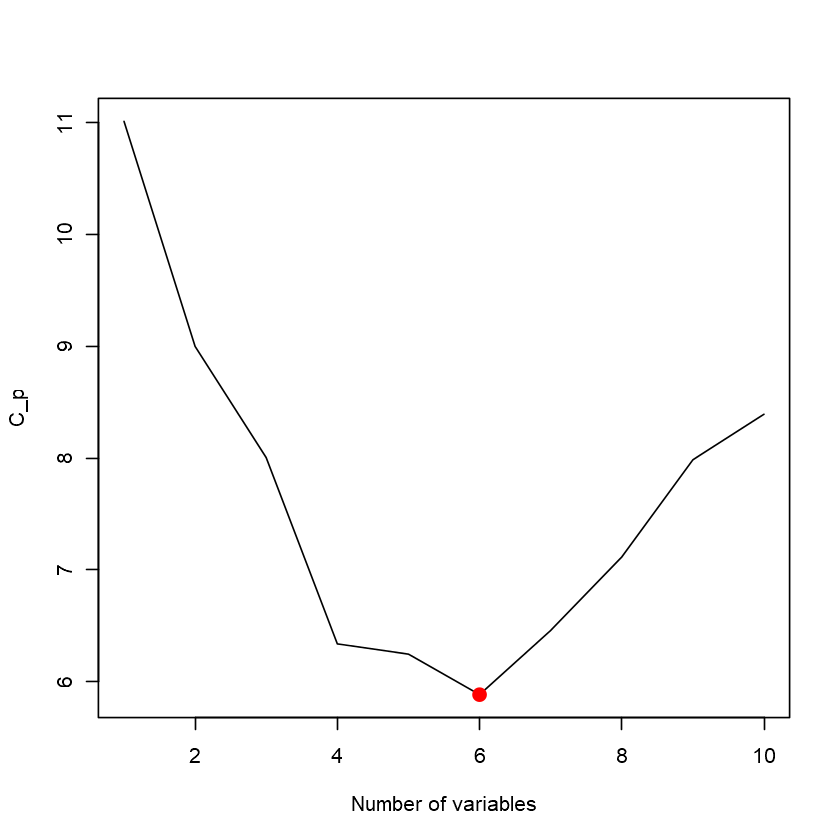

In [42]:
plot(reg.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
mincp = which.min(reg.summary$cp)
points(mincp, reg.summary$cp[mincp], col = "red", cex = 2, pch = 20)
mincp

The plot suggests that the best overall model is a model with 6 variables. The variables names and coefficients are :

In [43]:
coef(regfit.full, mincp)

(Intercept)   month.aug     day.sat     day.sun     day.tue         DMC 
 6.45967587 -4.93700184  6.68807918  4.29504899  8.21104361  0.04695192 
         RH 
-0.10324945

Similarly, we can use some other criteria, such as BIC and RSS. <br> Let's try BIC first.

(Intercept)     day.tue 
   7.511441    5.746559

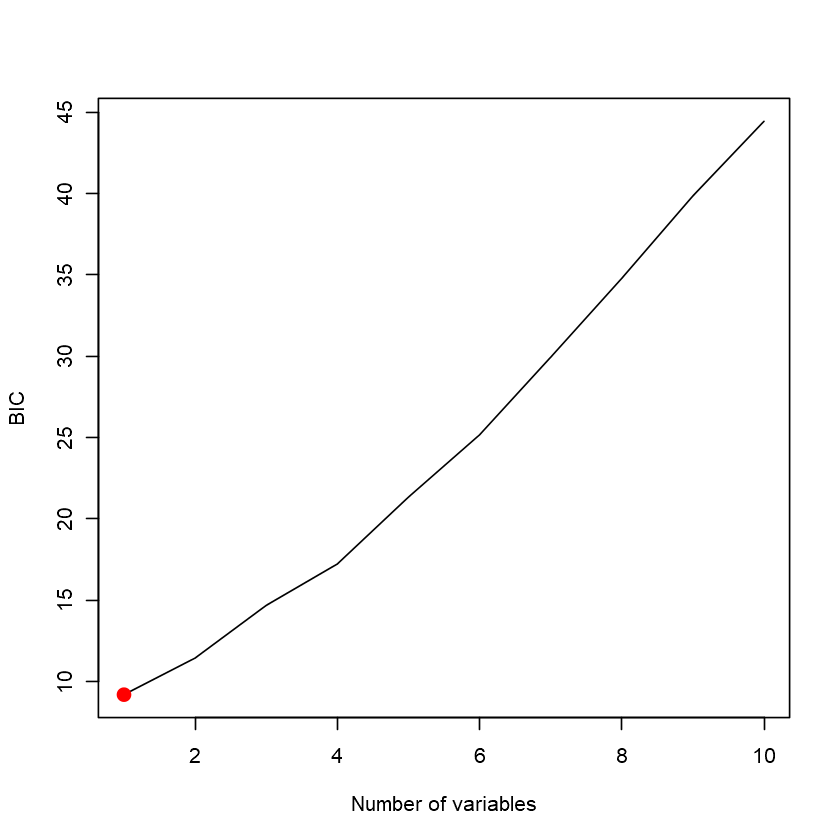

In [44]:
plot(reg.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
minbic = which.min(reg.summary$bic)
points(minbic, reg.summary$bic[minbic], col = "red", cex = 2, pch = 20)
coef(regfit.full, minbic)

The BIC gives us the different model with just one feature. <br>Now let ustry using adjusted  𝑅2

(Intercept)    month.aug    month.jul    month.jun    month.mar      day.sat 
 13.36936277  -7.33084567  -8.29016929 -10.72682589  -8.10153489   6.67218549 
     day.sun      day.tue          DMC           DC           RH 
  4.31755680   8.24730466   0.06586974  -0.01009552  -0.12446765

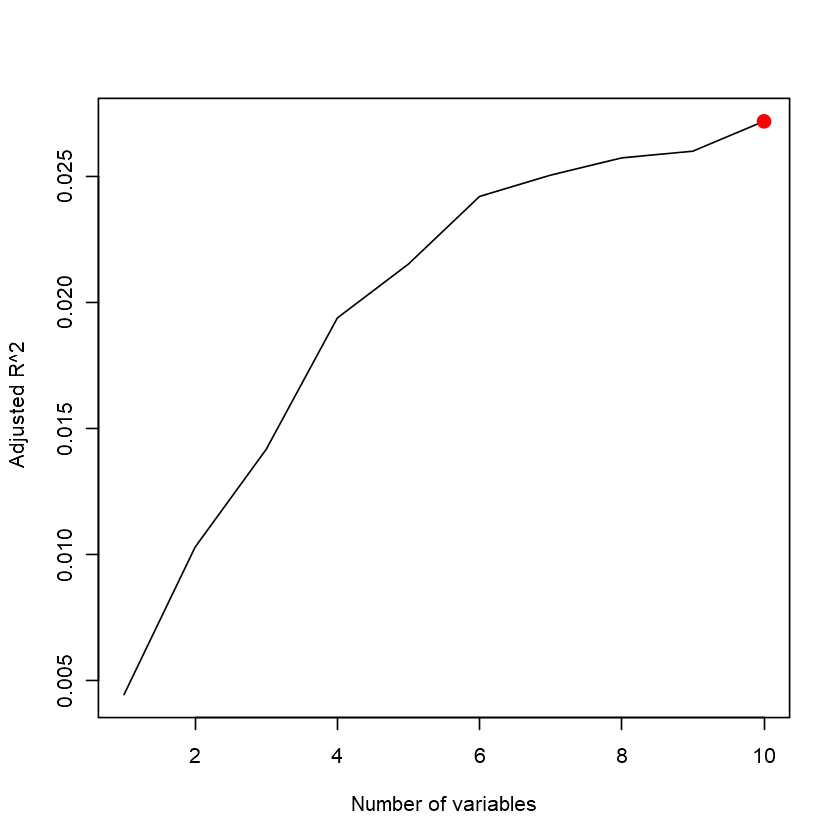

In [45]:
plot(reg.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
max_adjr2 = which.max(reg.summary$adjr2)
points(max_adjr2, reg.summary$adjr2[max_adjr2 ], col = "red", cex = 2, pch = 20)
coef(regfit.full, max_adjr2)

Adjusted R^2 criterion gives us all the 10 features to be relevant, because with increasing number of variables for our model the overall R^2 values increases by small proportions

<br>

Now let's have a look at the RSS plot

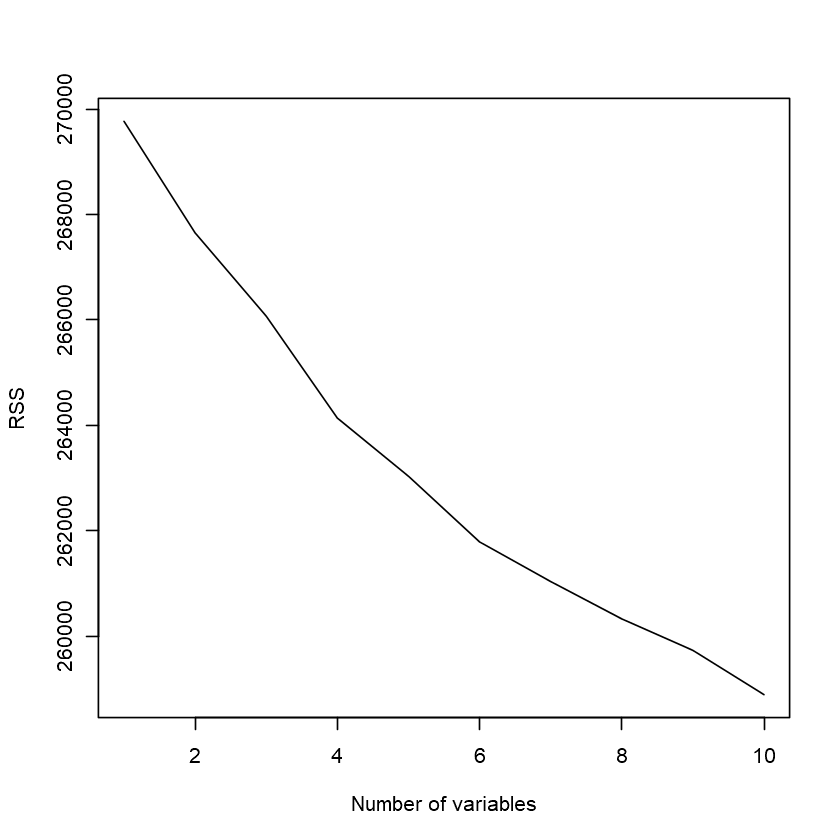

In [46]:
plot(reg.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")

We observed that RSS decreases as the number variable increases.

**We can conclude from the subset selection that considering all the 10 subset features obtained earlier would be a good idea as they give improved R^2 and reduced RSS** <br> <br>

## Feature Selection <br>

Concepts used:
* Correlations - from plots
* Interactions - manually checking
* p-values from lm()
* step function 
* Subset selection<br>

**Features having best correlation with the target as seen in the previous correlation plots :** <br>
* FFMC
* DMC
* DC
* temp
* RH  <br>

**Interactions** <br>
After checking model statistics using various interactions between features, i concluded few interactions to be statistically significant i.e having low p-values. They are:
* DMC:DC
* temp:DC
* log(rain+1):ISI <br>

**p-values** <br>
We are always interested in the features with lowest p-values. As seen from above summary(model) those are: <br>
* month.apr
* month.aug
* month.feb
* month.jul
* month.mar
* DMC
* DC <br>

**step function** <br>
Step function applied on our model reduced our model features to relevant one's. Final formula is given below: <br>
lm(formula = area ~ month.apr + month.aug + month.feb + month.jul + 
    month.jun + month.mar + day.fri + day.mon + day.thu + DMC + 
    DC + RH, data = new_bush_data.encoded) <br>

**Subset Selection** <br>

We implemented subset selection to select best performing features, based on 'rss', 'adjr2', 'cp' and 'bic'. We concluded with 10 features to be prominent for our model. They are:
* month.aug
* month.jul
* month.jun
* month.mar
* day.sat
* day.sun
* day.tue
* DMC
* DC
* RH
    


### Feature Transformations

Our dataset has many skewed features(as seen in the hist plots earlier). These are : <br>
* area - highly skewed
* rain - highly skewed
* DMC
* DC
* temp
* RH
* wind <br> <br>

log(x+1) tranformation seems to be relevant for highly skewed features like **area** and **rain** as they have many zero instances.

<br>

### Now let us apply the transformations and use selected features and interactions to check our model statistics.

In [47]:
fit1_encoded <- lm(log(area + 1) ~ wind + log(temp) + DMC + DC  + month.aug + month.dec + month.jul + month.jun + month.mar + DMC:DC   +  temp:DC + log(rain+1):ISI , data=new_bush_data.encoded)
summary(fit1_encoded)


Call:
lm(formula = log(area + 1) ~ wind + log(temp) + DMC + DC + month.aug + 
    month.dec + month.jul + month.jun + month.mar + DMC:DC + 
    temp:DC + log(rain + 1):ISI, data = new_bush_data.encoded)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7065 -0.9897 -0.5273  0.8177  4.2134 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.438e+00  8.606e-01   1.671 0.095362 .  
wind               4.075e-02  3.491e-02   1.167 0.243587    
log(temp)         -3.445e-01  3.629e-01  -0.949 0.342882    
DMC                1.619e-02  6.111e-03   2.650 0.008307 ** 
DC                -1.000e-03  6.497e-04  -1.539 0.124410    
month.aug         -6.334e-01  1.904e-01  -3.327 0.000943 ***
month.dec          1.309e+00  5.463e-01   2.397 0.016915 *  
month.jul         -7.106e-01  3.455e-01  -2.057 0.040244 *  
month.jun         -1.118e+00  4.616e-01  -2.421 0.015841 *  
month.mar         -4.900e-01  3.001e-01  -1.633 0.103185    
DMC:DC          

Positives from new model: <br>
* **Residual standard error:** Reduced from 22.98 to 1.284
* **Adjusted R-squared:** Increased from  0.02201 to 0.04882

### Diagnostic plots of the linear regression fit

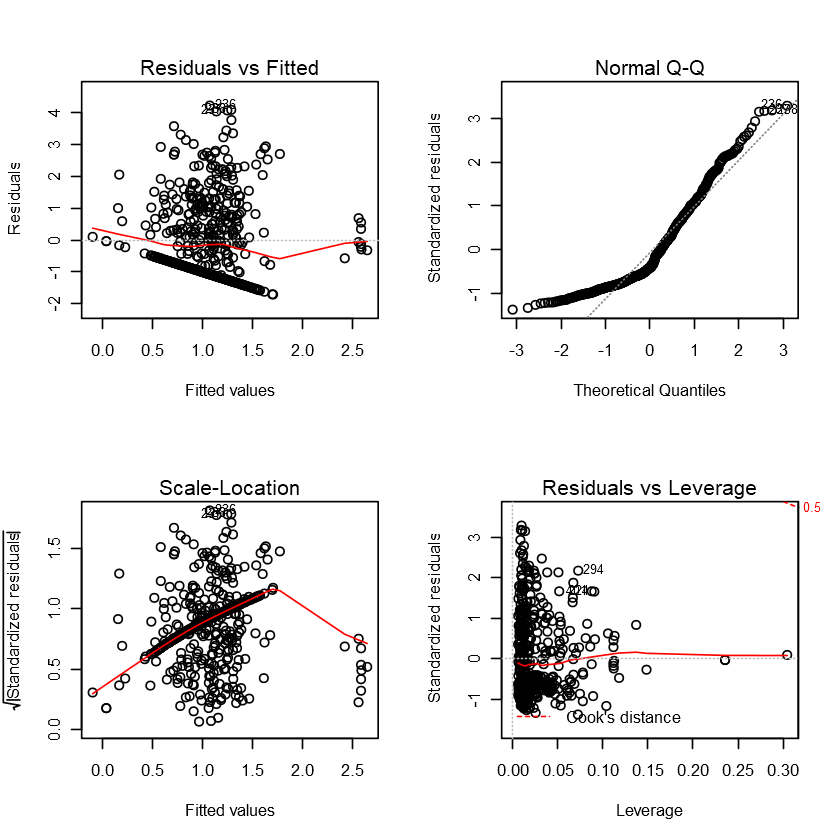

In [48]:
par(mfrow=c(2,2))
plot(fit1_encoded)

* **The residual vs fitted plot:** The first plot above shows that there could be a non-linear relationship between area and all the predictors, as the residuals are not scattered evenly.
* **The normal Q-Q plot:** The normal Q-Q plot shows if residuals are normally distributed.It seems that the residuals are somewhat distributed normally.
* **The scale-location plot:** It is used to check the assumption of equal variance by showing if residuals are spread equally along the ranges of predictors.  The scale-location plot shows that the residuals appear not to be randomly spread.
* **The residual-leverage plot:** We can barely see Cook’s distance lines because all cases are well inside of the Cook’s distance lines. Therefore no influential cases are observed.

### Now let us start applying different Models: <br>
1. Linear Regression
2. SVM
3. Random Forest

### Train-Test split

Let us first do the **train-test** split. <br>
Train data will be used to train our model, while test data is for validation. <br>
We will implement 80-20 train-test split i.e 80% of observations will be used for training and 20% will be used for testing or validation

In [49]:
smp_size <- floor(0.80 * nrow(new_bush_data.encoded))
set.seed(123)
train_ind <- sample(seq_len(nrow(new_bush_data.encoded)), size = smp_size)

train_bush_data <- new_bush_data.encoded[train_ind, ]
test_bush_data_with_target <- new_bush_data.encoded[-train_ind,]
test_bush_data_with_target$area_log <- log(test_bush_data_with_target$area + 1)
test_bush_data <- subset(new_bush_data.encoded[-train_ind,],select = -c(area))

In [50]:
dim(train_bush_data)
dim(test_bush_data)

[1] 403  28

[1] 101  27

In [51]:
head(train_bush_data,4)

,X,Y,month.apr,month.aug,month.dec,month.feb,month.jan,month.jul,month.jun,month.mar,...,day.tue,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
356,4,4,0,0,0,0,0,0,0,0,...,0,92.1,99.0,745.3,9.6,20.8,35,4.9,0,13.06
440,1,3,0,0,0,0,0,0,0,0,...,0,91.1,91.3,738.1,7.2,19.1,46,2.2,0,0.33
342,8,6,0,0,0,0,0,0,0,0,...,0,91.9,111.7,770.3,6.5,15.7,51,2.2,0,0.00
14,6,5,0,0,0,0,0,0,0,0,...,0,90.9,126.5,686.5,7.0,21.3,42,2.2,0,0.00


In [52]:
head(test_bush_data,4)

,X,Y,month.apr,month.aug,month.dec,month.feb,month.jan,month.jul,month.jun,month.mar,...,day.thu,day.tue,FFMC,DMC,DC,ISI,temp,RH,wind,rain
1,7,5,0,0,0,0,0,0,0,1,...,0,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0
15,6,5,0,0,0,0,0,0,0,0,...,0,0,92.9,133.3,699.6,9.2,26.4,21,4.5,0
17,5,5,0,0,0,0,0,0,0,1,...,0,0,91.7,35.8,80.8,7.8,15.1,27,5.4,0
19,6,4,0,0,0,0,0,0,0,1,...,0,0,89.2,27.9,70.8,6.3,15.9,35,4.0,0


### MODEL  -  1 <br>

#### LINEAR REGRESSION MODEL
    

In [53]:
# Training the model
l_model <- lm(log(area + 1) ~ wind + log(temp) + DMC + DC  + month.aug + month.dec + month.jul + month.jun + month.mar + 
              DMC:DC   +  temp:DC + log(rain+1):ISI , data=train_bush_data)
# Testing the model
l_model_predict <- predict(l_model,test_bush_data)

#### K-fold Cross Validation for Linear Model <br>
Now we will implement k-fold cross validation on our training dataset to develop linear model. <br>
After iterating over folds from 10 to 22, i decided to go with 21 as it had better Rsquared value

In [54]:
# library(caret)

# for (n in 10:22) {
    
#         # Define train control for k fold cross validation
#     train_control <- trainControl(method="cv", number=n)

#     # Fit Linear Model
#     l_model_cv <- train(log(area + 1) ~ wind + log(temp) + DMC + DC  + month.aug + month.dec + month.jul +
#                    month.jun + month.mar + DMC:DC   +  temp:DC + log(rain+1):ISI,
#                    data=train_bush_data, trControl=train_control, method="lm")
#     # Summarise Results
#     print(n)
#     print(l_model_cv)
    
# }


Implementing 21-fold cross validation to train our model.

In [55]:
library(caret)
# Define train control for k fold cross validation
train_control <- trainControl(method="cv", number=21)

# Fit Linear Model
l_model_cv <- train(log(area + 1) ~ wind + log(temp) + DMC + DC  + month.aug + month.dec + month.jul +
               month.jun + month.mar + DMC:DC   +  temp:DC + log(rain+1):ISI,
               data=train_bush_data, trControl=train_control, method="lm")
# Summarise Results
print(l_model_cv)

# Testing the model
l_model_cv_predict <- predict(l_model_cv,test_bush_data)

Linear Regression 

403 samples
 11 predictor

No pre-processing
Resampling: Cross-Validated (21 fold) 
Summary of sample sizes: 384, 384, 384, 384, 383, 384, ... 
Resampling results:

  RMSE      Rsquared    MAE     
  1.308999  0.06852368  1.106693

Tuning parameter 'intercept' was held constant at a value of TRUE


In [56]:
head(l_model_cv_predict)

1        15        17        19        28        37 
0.8835888 1.7768290 0.7989402 0.5434656 1.3448222 1.2262430

We can see that after implementing 21-fold cross validation, the predictions do not change and are similar to our normal model. So we wont be considering k-fold for our models.

### MODEL - 2 <br>
#### SUPPORT VECTOR MACHINE - REGRESSION (SVR)

In [57]:
#Install Package
# install.packages("e1071")

#Load Library
library(e1071)

#Training the model
svm_model <- svm(log(area + 1) ~ wind + log(temp) + DMC + DC  + month.aug + month.dec + month.jul + month.jun + month.mar +
                 DMC:DC   +  temp:DC + log(rain+1):ISI, data=train_bush_data)

#Testing the model
svm_model_predict = predict(svm_model, test_bush_data)

Warning message:
"package 'e1071' was built under R version 3.6.3"

### MODEL - 3 <br>
#### RANDOM FOREST - REGRESSION

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:psych':

    outlier

The following object is masked from 'package:ggplot2':

    margin



,%IncMSE,IncNodePurity
wind,4.5312297,12.9613620
log(temp),6.9265327,22.4105953
DMC,5.6944636,15.1524302
DC,7.6684408,18.3099909
month.aug,5.1370793,3.5143052
month.dec,10.1843947,5.5316977
month.jul,-0.6684808,0.5269609
month.jun,-1.2314283,0.2183448
month.mar,2.6199064,1.2109525
rain,1.6423656,0.1415925


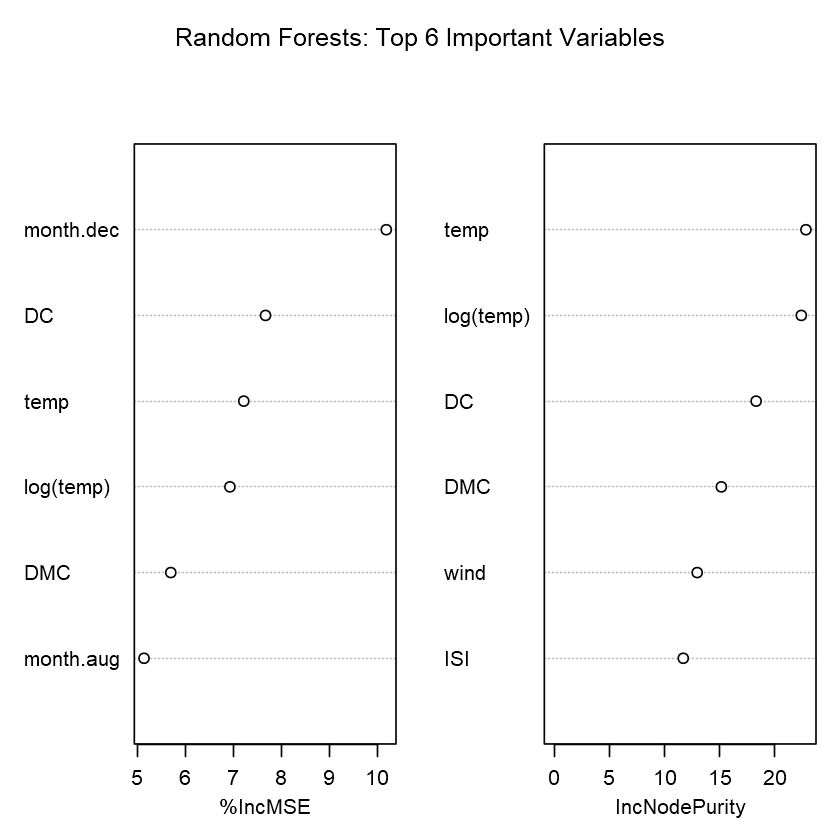

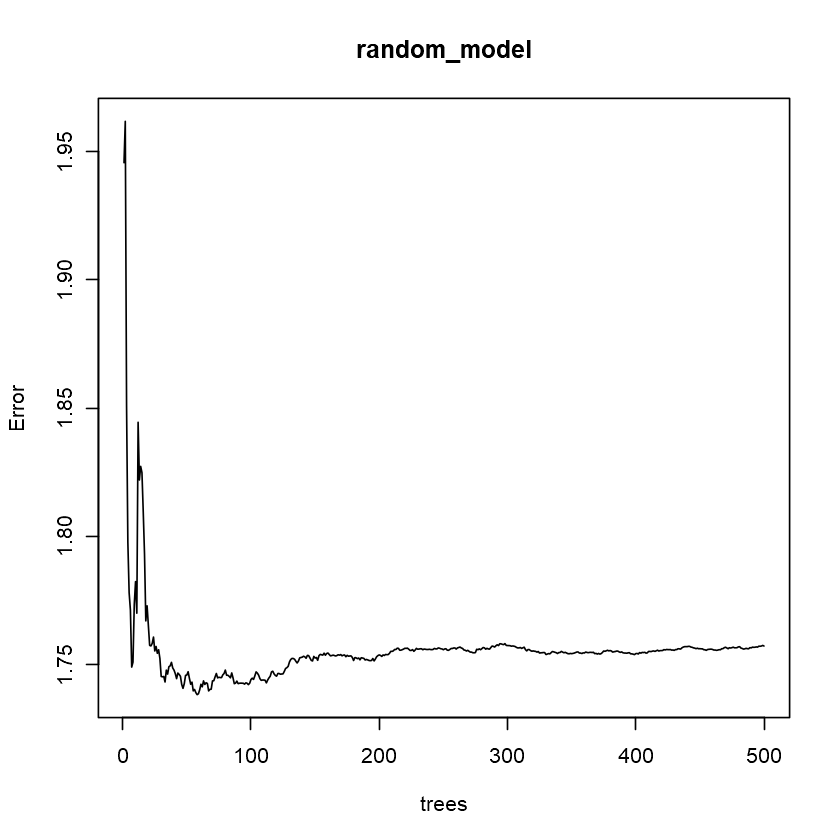

In [58]:
library(randomForest)

random_model <- randomForest(log(area + 1) ~ wind + log(temp) + rain:ISI + DMC + DC  + month.aug + month.dec + month.jul + month.jun +
                             month.mar + DMC:DC   +  temp:DC, data=train_bush_data, maxnodes=10,importance = TRUE)

par(mfrow = c(1, 1))
varImpPlot(random_model, n.var = 6, main = "Random Forests: Top 6 Important Variables")
importance(random_model)
plot(random_model)


random_model_predict <- predict(random_model, newdata=test_bush_data)

## 4. Model Comparsion<a class="anchor" id="sec_4"></a>

Let us now calculate few model metrics based on the validation dataset. <br>
We have already tested all three models on the validation set and obtained the predictions <br>


In [59]:
# LINEAR MDOEL
library(caret)


predictionvsactual <- data.frame(predictions = l_model_predict,actual_values = test_bush_data_with_target$area_log)

#RMSE
cat("RMSE for linear regression")
rmse_linear = RMSE(l_model_predict,test_bush_data_with_target$area_log)
rmse_linear

#R^2
cat("R2 for linear regression : ")
R2_linear = R2(l_model_predict,test_bush_data_with_target$area_log)
R2_linear

#MAE
cat("MAE for linear regression")
MAE_linear = MAE(l_model_predict,test_bush_data_with_target$area_log)
MAE_linear
head(predictionvsactual)

# creating a dataframe for metrics
metrics_df_linear <- data.frame('LINEAR',rmse_linear, R2_linear, MAE_linear)
names(metrics_df_linear) <- c("Model", "RMSE", "R^2", "MAE")

RMSE for linear regression

[1] 1.254658

R2 for linear regression : 

[1] 0.005606668

MAE for linear regression

[1] 1.021021

,predictions,actual_values
1,0.8835888,0
15,1.7768290,0
17,0.7989402,0
19,0.5434656,0
28,1.3448222,0
37,1.2262430,0


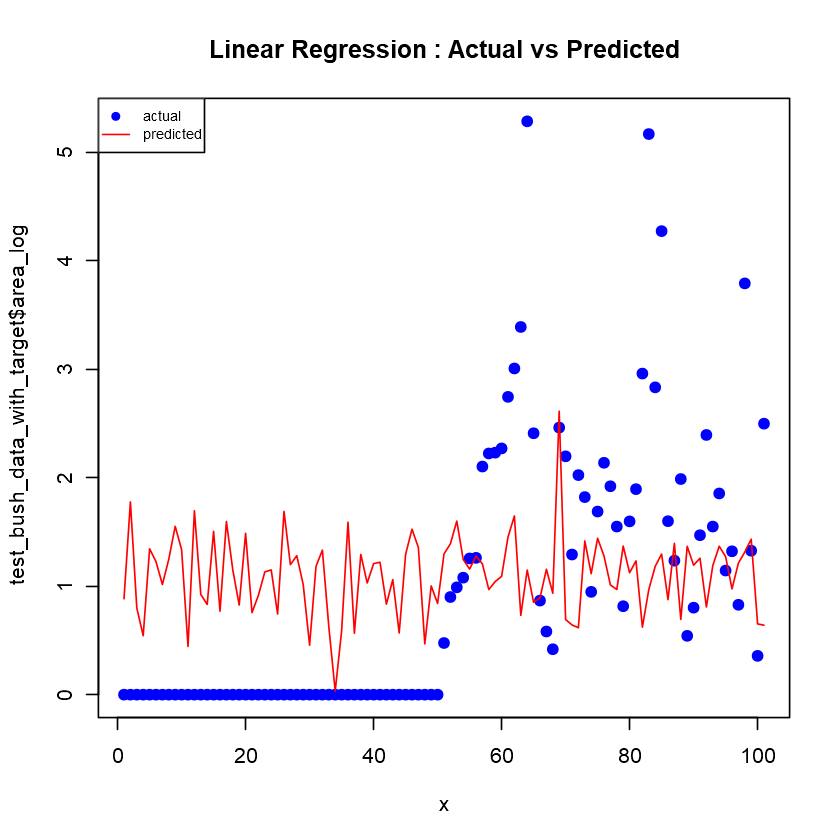

In [60]:
x=1:length(test_bush_data_with_target$area_log)

plot(x, test_bush_data_with_target$area_log,pch=19, col="blue")

lines(x, l_model_predict, col="red")

legend("topleft", legend = c("actual", "predicted"),
       col = c("blue", "red"), pch = c(19,NA), lty = c(NA,1),  cex = 0.7)

title('Linear Regression : Actual vs Predicted')

In [61]:
#SVM MODEL
library(caret)

predictionvsactual_svm <- data.frame(predictions = svm_model_predict,actual_values = test_bush_data_with_target$area_log)

#RMSE
cat("RMSE for SVM regression")
rmse_svm = RMSE(svm_model_predict,test_bush_data_with_target$area_log)
rmse_svm

#R^2
cat("R2 for SVM regression : ")
R2_svm = R2(svm_model_predict,test_bush_data_with_target$area_log)
R2_svm

#MAE
cat("MAE for SVM regression")
MAE_svm = MAE(svm_model_predict,test_bush_data_with_target$area_log)
MAE_svm
head(predictionvsactual_svm)

# creating a dataframe for metrics
metrics_df_svm <- data.frame('SVM',rmse_svm, R2_svm, MAE_svm)
names(metrics_df_svm) <- c("Model", "RMSE", "R^2", "MAE")

RMSE for SVM regression

[1] 1.328966

R2 for SVM regression : 

[1] 0.001386605

MAE for SVM regression

[1] 0.9138075

,predictions,actual_values
1,0.3101288,0
15,1.2226071,0
17,0.1077186,0
19,0.1549123,0
28,0.8820874,0
37,0.4149393,0


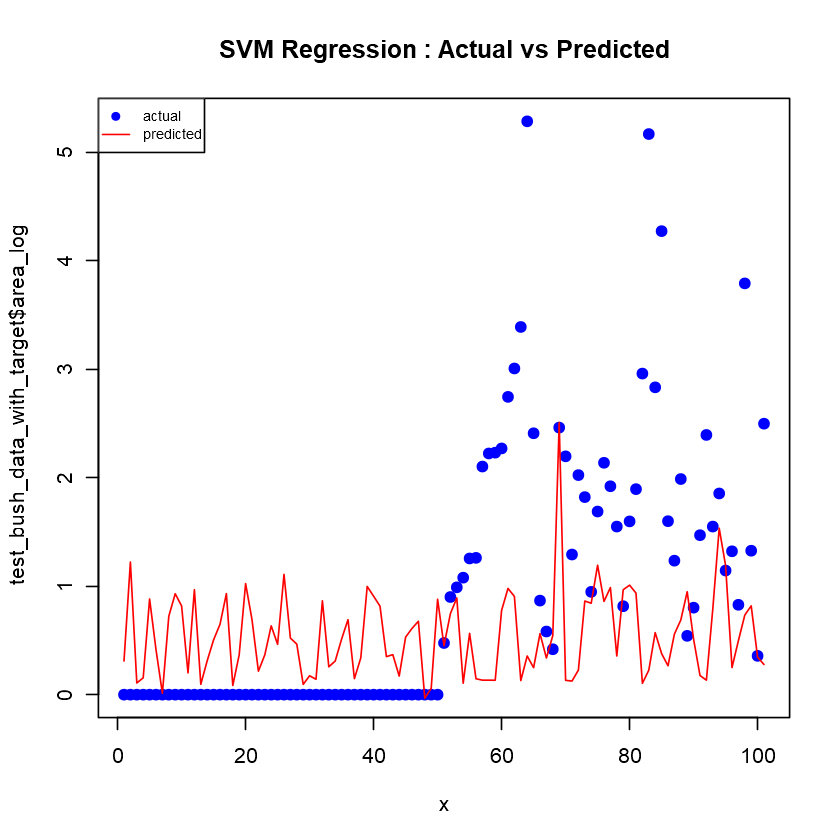

In [62]:
x=1:length(test_bush_data_with_target$area_log)
plot(x, test_bush_data_with_target$area_log,pch=19, col="blue")
lines(x, svm_model_predict, col="red")
legend("topleft", legend = c("actual", "predicted"),
       col = c("blue", "red"), pch = c(19,NA), lty = c(NA,1),  cex = 0.7)
title('SVM Regression : Actual vs Predicted')

In [63]:
#RANDOM FOREST
library(caret)

predictionvsactual_random <- data.frame(predictions = random_model_predict,actual_values = test_bush_data_with_target$area_log)

#RMSE
cat("RMSE for Random Forest")
rmse_rf = RMSE(random_model_predict,test_bush_data_with_target$area_log)
rmse_rf

#R^2
cat("R2 for Random Forest : ")
R2_rf = R2(random_model_predict,test_bush_data_with_target$area_log)
R2_rf

#MAE
cat("MAE for Random Forest")
MAE_rf = MAE(random_model_predict,test_bush_data_with_target$area_log)

head(predictionvsactual_random)

# creating a dataframe for metrics
metrics_df_rf <- data.frame('Random Forest',rmse_rf, R2_rf, MAE_rf)
names(metrics_df_rf) <- c("Model", "RMSE", "R^2", "MAE")

RMSE for Random Forest

[1] 1.230132

R2 for Random Forest : 

[1] 0.00633711

MAE for Random Forest

,predictions,actual_values
1,0.9608758,0
15,1.5581710,0
17,0.8027108,0
19,0.8264764,0
28,1.2898095,0
37,0.9063041,0


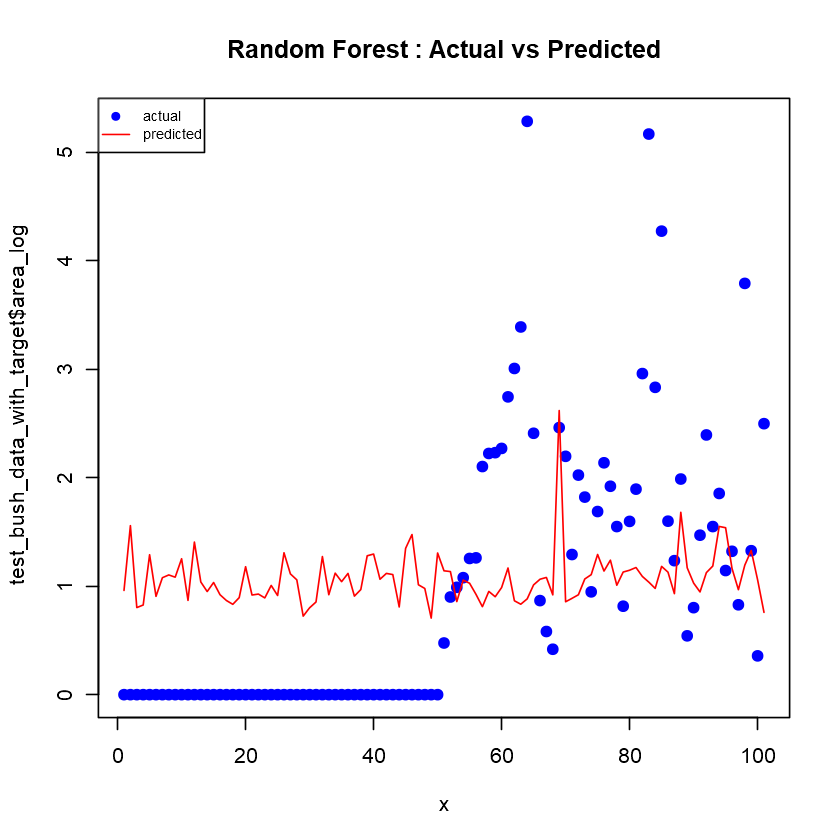

In [64]:
x=1:length(test_bush_data_with_target$area_log)
plot(x, test_bush_data_with_target$area_log,pch=19, col="blue")
lines(x, random_model_predict, col="red")
legend("topleft", legend = c("actual", "predicted"),
       col = c("blue", "red"), pch = c(19,NA), lty = c(NA,1),  cex = 0.7)
title('Random Forest : Actual vs Predicted')

In [65]:
# Combining all the metrics dataframes for all models
metric_df_allmodels <- rbind(rbind(metrics_df_linear, metrics_df_svm),metrics_df_rf)
rownames(metric_df_allmodels) <- 1:3
metric_df_allmodels

Model,RMSE,R^2,MAE
LINEAR,1.254658,0.005606668,1.0210211
SVM,1.328966,0.001386605,0.9138075
Random Forest,1.230132,0.006337110,1.0038829


#### Understand from metrics dataframe<br>

* RMSE : Lower the model RMSE value, better the model. Random Forest model has the least RMSE value
* R^2 : Higher the model R^2 value, better the model. Random Forest model has the highest R^2 value
* MAE : Lower the model MSE value, better the model. SVM has the least MSE value

#### Undersatnding from the actual vs predicted plots <br>
In case of Linear Regression and SVM plots, we can observe that the preicted values have a higher deviation from the actual values, especially were actual values are equal to zero. <br>
Random Forest plot shows a slighlty better fit in capturing the actual vales were taget i.e area=0 and higher.

## 5. Variable Identification and Explanation <a class="anchor" id="sec_5"></a>

Concepts used:
* Correlations - from plots
* Interactions - manually checking
* p-values from lm()
* step function 
* Subset selection<br>

**Features having best correlation with the target as seen in the previous correlation plots :** <br>
* FFMC
* DMC
* DC
* temp
* RH  <br>

**Interactions** <br>
After checking model statistics using various interactions between features, i concluded few interactions to be statistically significant i.e having low p-values. They are:
* DMC:DC
* temp:DC
* log(rain+1):ISI <br>

**p-values** <br>
We are always interested in the features with lowest p-values. As seen from above summary(model) those are: <br>
* month.apr
* month.aug
* month.feb
* month.jul
* month.mar
* DMC
* DC <br>

**step function** <br>
Step function applied on our model reduced our model features to relevant one's. Final formula is given below: <br>
lm(formula = area ~ month.apr + month.aug + month.feb + month.jul + 
    month.jun + month.mar + day.fri + day.mon + day.thu + DMC + 
    DC + RH, data = new_bush_data.encoded) <br>

**Subset Selection** <br>

We implemented subset selection to select best performing features, based on 'rss', 'adjr2', 'cp' and 'bic'. We concluded with 10 features to be prominent for our model. They are:
* month.aug
* month.jul
* month.jun
* month.mar
* day.sat
* day.sun
* day.tue
* DMC
* DC
* RH
    
### FINAL Prominent Features taken into consideration: <br>
1. wind
2. temp
3. DMC
4. DC
5. rain
6. month - mar,june,july and aug
<br>

**NOTE: All feature interactions and tranformation have been applied on these selected features**

## 6. Conclusion <a class="anchor" id="sec_6"></a>

This problem was modeled as a regression task, where the aim was the prediction of the burned area. <br> 
Three different algorithms, including Support Vector Machines (SVM), Linear Regression and Random Forest were tested. <br>




The proposed solution, which is based on Random Forest requires only five direct weather inputs (i.e. temperature, rain, DC,DMC  and wind speed). The drawback is the lower predictive accuracy.

## 7. References <a class="anchor" id="sec_7"></a>

- http://www.columbia.edu/~yh2693/ForestFire.html
- http://www3.dsi.uminho.pt/pcortez/fires.pdf
- https://www.kaggle.com/elikplim/predict-the-burned-area-of-forest-fires
- https://daviddalpiaz.github.io/r4sl/regression-for-statistical-learning.html
- https://www.r-project.org/
- https://rpubs.com/
- https://www.statmethods.net/advgraphs/ggplot2.html
- Tutorials